In [24]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
def cdist(X, Y):
    X2 = tf.reduce_sum(tf.square(X), 1)
    Y2 = tf.reduce_sum(tf.square(Y), 1)
    X2 = tf.reshape(X2, [-1, 1])
    Y2 = tf.reshape(Y2, [1, -1])
    # return pairwise euclidead difference matrix
    distances = tf.sqrt(tf.maximum(
        X2 + Y2 - 2 * tf.matmul(X, Y, False, True), 0.0))
    assert distances.shape == [X.shape[0], Y.shape[0]]
    return distances

In [3]:
def compute_T(K, u, v, n_iter=20, tol=1e-5):
    """
    Parameters:
    -----------
        D: 2D array, [M, N]
        r: 1D array, [M, ]
        c: 1D array, [N, ]
        lambd: regularization parameter in Sinkhorn divergence
        p: power of the Wasserstein space
        n_iter: number of iterations for matrix balancing
        tol: tolerance for stopping matrix balancing iterations
    """
    r = tf.random.uniform([int(u.shape[0]), 1], dtype=tf.float64)
    c = tf.random.uniform([int(v.shape[0]), 1], dtype=tf.float64)
    r_new = -tf.ones([int(u.shape[0]), 1], dtype=tf.float64)
    c_new = -tf.ones([int(v.shape[0]), 1], dtype=tf.float64)

    def cond(r, c, r_new, c_new):
        r_ok = tf.reduce_all(tf.abs(r_new - r) < tol)
        c_ok = tf.reduce_all(tf.abs(c_new - c) < tol)
        return tf.logical_and(r_ok, c_ok)

    def body(r, c, r_new, c_new):
        r, c = r_new, c_new
        r_new = u / tf.matmul(K, c, False, False)
        c_new = v / tf.matmul(K, r, True, False)
        return [r, c, r_new, c_new]

    tf.while_loop(cond, body, [r, c, r_new, c_new], maximum_iterations=n_iter)

    T_opt = tf.matmul(tf.diag(tf.reshape(r, (-1,))),
                      tf.matmul(K, tf.diag(tf.reshape(c, (-1,)))))

    return T_opt

In [18]:
def wasserstein_distance(n1, n2, embeddings, u, v, lambd, p=1, n_iter=20, tol=1e-5):
    support_1 = embeddings[n1, :, :]
    support_2 = embeddings[n2, :, :]
    D = cdist(support_1, support_2)
    D_p = tf.pow(D, p)
    K = tf.exp(-D_p / lambd)
    T = compute_T(K, u, v, n_iter, tol)

#     distance = tf.trace(tf.matmul(D_p, T, False, True)) + lambd * \
#         tf.trace(tf.matmul(T, tf.log(T) -
#                            tf.ones(T.shape, dtype=tf.float64), False, True))
    distance = tf.trace(tf.matmul(D_p, T, False, True))
    return distance

In [5]:
def embedding_distances(pairs, embeddings, u, v, lambd, p=1, n_iter=1000, tol=1e-5):

    results = tf.map_fn(lambda x: wasserstein_distance(
        x[0], x[1], embeddings, u, v, lambd, p, n_iter, tol), pairs, dtype=tf.float64)
    return results

In [64]:
def train(node_pairs, obj_distances, lr=0.1, n_epochs=200, patience=10, u_v=None, embed_dim=4, ground_dim=2, lambd=0.5, p=1, mat_bal_iter=50, mat_bal_tol=1e-5):
    if u_v is None:
        u = tf.ones([embed_dim, 1], dtype=tf.float64) / embed_dim
        v = tf.ones([embed_dim, 1], dtype=tf.float64) / embed_dim
    
    n_nodes = int(obj_distances.shape[0])

    Node_Pairs = tf.placeholder(dtype=tf.int32, shape=[None, 2], name='Node_Pairs')
    Obj_Distances = tf.placeholder(dtype=tf.float64, shape=[None], name='Obj_Distances')

    Embeddings = tf.Variable(tf.random.uniform([n_nodes, embed_dim, ground_dim], 
                                               minval=-1., maxval=1., dtype=tf.float64), 
                             name='Embeddings')
    Embed_Distances = embedding_distances(Node_Pairs, Embeddings, u, v, lambd, p, mat_bal_iter, mat_bal_tol)
    Loss = tf.reduce_mean(tf.abs(Embed_Distances - Obj_Distances) / Obj_Distances)
    Jac = tf.gradients(ys=Embed_Distances, xs=Embeddings)
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(Loss)
    init_op = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init_op)
        # Lists for storing the changing Cost and Accuracy in every Epoch
        loss_history = []

        best_loss = 1000
        early_stopping_counter = 0
        for epoch in range(n_epochs):
            # Running the Optimizer
            _, embeddings, embed_distances, loss, jac = sess.run([optimizer, Embeddings, Embed_Distances, Loss, Jac], 
                                                                feed_dict={Node_Pairs: node_pairs, 
                                                                           Obj_Distances: obj_distances})
            # Storing loss to the history
            loss_history.append(loss)
            # Displaying result on current Epoch
            if epoch % 1 == 0 and epoch != 0:
                print("Epoch: {}/{}, loss: {}".format(epoch, n_epochs, loss))
            # Early stopping check
            if loss < best_loss:
                best_loss = loss
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
            if early_stopping_counter >= patience:
                break
#         embeddings = sess.run(Embeddings)
    return embeddings, loss_history, embed_distances, jac

In [65]:
from graph_generator import GraphGenerator

g = GraphGenerator(graph_type='scale-free', n_nodes=128)
node_pairs = g.get_node_pairs()
obj_distances = g.get_obj_distances()

In [89]:
embeddings, loss_history, embed_distances, jac = train(node_pairs, obj_distances, lr=0.1, n_epochs=200, patience=10, 
                                                       embed_dim=15, lambd=10., mat_bal_iter=100)

Epoch: 1/200, loss: 21.299774358912234
Epoch: 2/200, loss: 17.950313540428002
Epoch: 3/200, loss: 14.687083597662053
Epoch: 4/200, loss: 11.61322325115387
Epoch: 5/200, loss: 8.682573357924086
Epoch: 6/200, loss: 6.292150908158609
Epoch: 7/200, loss: 4.445069692325699
Epoch: 8/200, loss: 3.298595761046368
Epoch: 9/200, loss: 3.0455109757586047
Epoch: 10/200, loss: 3.4728417695371436
Epoch: 11/200, loss: 4.016833339854512
Epoch: 12/200, loss: 4.351031507289773
Epoch: 13/200, loss: 4.373949333501172
Epoch: 14/200, loss: 4.1545860960090515
Epoch: 15/200, loss: 3.7072823379656206
Epoch: 16/200, loss: 3.1464357661114777
Epoch: 17/200, loss: 2.5164229420060256
Epoch: 18/200, loss: 1.896951874125459
Epoch: 19/200, loss: 1.4032696162596516
Epoch: 20/200, loss: 1.1320439736915242
Epoch: 21/200, loss: 1.1173354762496568
Epoch: 22/200, loss: 1.2752716336849155
Epoch: 23/200, loss: 1.3913681529883675
Epoch: 24/200, loss: 1.3613062293849336
Epoch: 25/200, loss: 1.1944873194937227
Epoch: 26/200, los

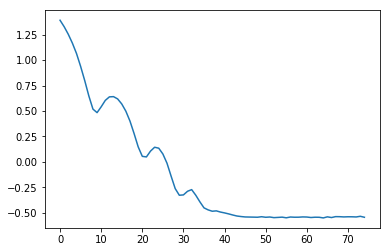

In [90]:
log_loss = np.log10(loss_history)
plt.figure()
plt.plot(log_loss)
plt.show()

In [91]:
embeddings[0]

array([[ 0.05474885,  0.00355104],
       [ 0.00751298,  0.00155503],
       [ 0.01300453, -0.01978361],
       [-0.0395533 , -0.01561627],
       [-0.00929674, -0.02427801],
       [ 0.00593229, -0.00431298],
       [-0.00084188, -0.00936868],
       [-0.02188926, -0.00123593],
       [-0.00371875, -0.00722894],
       [ 0.02578223, -0.01451805],
       [-0.00553122, -0.01060056],
       [ 0.0129108 , -0.001781  ],
       [ 0.00094543, -0.02382991],
       [ 0.00301625, -0.03921987],
       [ 0.00568843, -0.01877826]])

In [41]:
from scipy.spatial.distance import squareform
import seaborn as sns

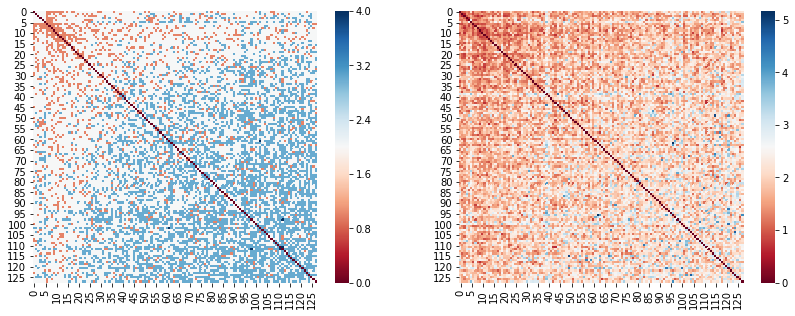

In [92]:
plt.figure(figsize=(14,5))

true_distance = squareform(obj_distances)
plt.subplot(121)
sns.heatmap(true_distance, cmap='RdBu')

pred_distance = squareform(embed_distances)
plt.subplot(122)
sns.heatmap(pred_distance, cmap='RdBu')